In [160]:
import numpy as np
import pandas as pd

import collections
import string
import nltk
import plotly.express as px

from nltk.corpus import stopwords
from collections import defaultdict
from textblob import TextBlob

from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Embedding, LSTM, Dropout
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import json
data = pd.read_json('/Users/mahima.sharma/Downloads/Sarcasm_Headlines_Dataset_v2.json', lines=True, orient='columns', encoding='utf-8')

In [3]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(data, test_size = 0.3, random_state = 101)

train_df = train_df.reset_index()
train_df = train_df.drop('index', axis = 1)

test_df = test_df.reset_index()
test_df = test_df.drop('index', axis = 1)

<b><h2> 1. Exploratory Data Analysis and Visualization</h2></b>

In [4]:
print('There are {} rows and {} columns in the training dataset'.format(train_df.shape[0], train_df.shape[1]))
print('There are {} rows and {} columns in the testing dataset'.format(test_df.shape[0], test_df.shape[1]))

There are 20033 rows and 3 columns in the training dataset
There are 8586 rows and 3 columns in the testing dataset


In [5]:
train_df.head()

,is_sarcastic,headline,article_link
0,0,'very angry badger' seizes part of 500-year-ol...,https://www.huffingtonpost.com/entry/badger-ca...
1,1,comic-con opens with traditional superhero fly...,https://entertainment.theonion.com/comic-con-o...
2,0,against divestment -- why walking away won't m...,https://www.huffingtonpost.com/entry/against-d...
3,1,area 93-year-old has death-after-life experience,https://local.theonion.com/area-93-year-old-ha...
4,1,man excited to give visiting friends the real ...,https://www.theonion.com/man-excited-to-give-v...


In [6]:
#The article link (HuffPost or The Onion) gives info on whether the title is sarcastic or not so we should drop it
train_df = train_df.drop('article_link', axis = 1) 
test_df = test_df.drop('article_link', axis = 1) 

In [7]:
train_df.groupby('is_sarcastic').describe()

headline         \
                count unique   
is_sarcastic                   
0               10495  10472   
1                9538   9490   

                                                                      
                                                            top freq  
is_sarcastic                                                          
0                                                sunday roundup   10  
1             'no way to prevent this,' says only nation whe...   10

<h4>Count of Target Variable </h4>

In [8]:
sarcastic = train_df[train_df['is_sarcastic'] == 1].shape[0]
normal = train_df[train_df['is_sarcastic'] == 0].shape[0]

<BarContainer object of 1 artists>

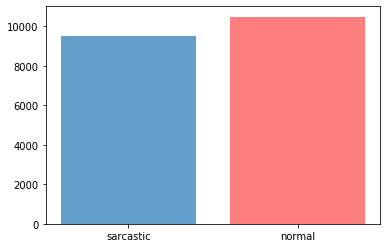

In [9]:
plt.bar('sarcastic', sarcastic, alpha = 0.7)
plt.bar('normal', normal, color = 'r', alpha = 0.5)

<h4>Length of titles </h4>

In [10]:
len_nor = train_df[train_df['is_sarcastic'] == 0]['headline'].str.len()
len_sar = train_df[train_df['is_sarcastic'] == 1]['headline'].str.len()

Text(0.5, 1.0, 'Normal Titles')

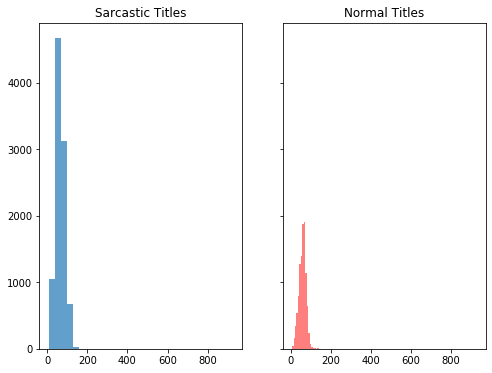

In [11]:
fig, axes = plt.subplots(1,2, figsize = (8,6), sharey = True, sharex = True)
axes[0].hist(len_sar, alpha = 0.7, bins = 30)
axes[0].set_title('Sarcastic Titles')
axes[1].hist(len_nor, color = 'r', alpha = 0.5, bins = 30)
axes[1].set_title('Normal Titles')

Sarcastic headlines have length up to around 200 whereas non sarcastic headlines have length of atmost 150

<h4>Number of words in each type of headline</h4>

In [12]:
words_sarcastic = train_df[train_df['is_sarcastic'] == 1]['headline'].str.split().map(lambda x : len(x))
words_normal = train_df[train_df['is_sarcastic'] == 0]['headline'].str.split().map(lambda x : len(x))

Text(0.5, 1.0, 'Normal Titles')

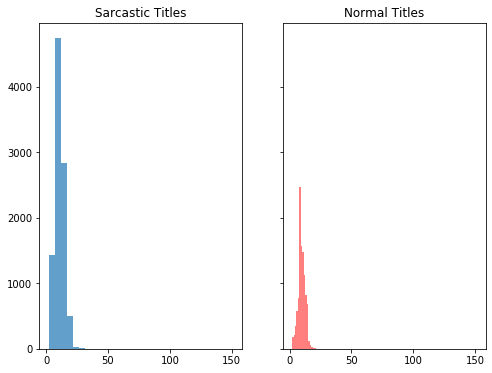

In [13]:
fig, axes = plt.subplots(1,2, figsize = (8,6), sharey = True, sharex = True)
axes[0].hist(words_sarcastic, alpha = 0.7, bins = 30)
axes[0].set_title('Sarcastic Titles')
axes[1].hist(words_normal, color = 'r', alpha = 0.5, bins = 30)
axes[1].set_title('Normal Titles')

Both types of titles have around 25 words in the title

<h4>Most common words </h4>

In [14]:
def corpus(num):
    corpus = []
    for sentence_list in train_df[train_df['is_sarcastic'] == num]['headline'].str.split():
        for word in sentence_list:
            corpus.append(word)
    return corpus

In [15]:
corpus_sar = corpus(1)
corpus_nor = corpus(0)

In [16]:
common_sar = defaultdict(int)

for word in corpus_sar:
    if word not in stopwords.words('english'):
        common_sar[word] +=1

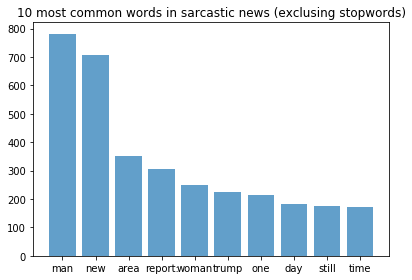

In [17]:
sar_list = sorted(common_sar.items(), key = lambda x : x[1], reverse = True)[:10]
x, y = zip(*sar_list)
plt.bar(x,y, alpha = 0.7)
plt.title('10 most common words in sarcastic news (exclusing stopwords)')
plt.tight_layout()

In [18]:
common_nor = defaultdict(int)

for word in corpus_nor:
    if word not in stopwords.words('english'):
        common_nor[word] +=1

In [19]:
nor_list = sorted(common_nor.items(), key = lambda x : x[1], reverse = True)[:10]

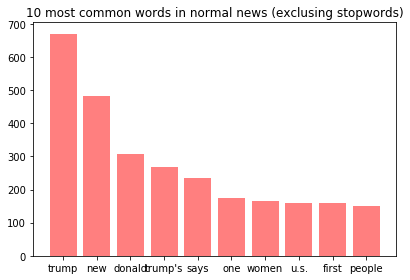

In [20]:
nor_list = sorted(common_nor.items(), key = lambda x : x[1], reverse = True)[:10]
x, y = zip(*nor_list)
plt.bar(x,y, color = 'r',alpha = 0.5)
plt.title('10 most common words in normal news (exclusing stopwords)')
plt.tight_layout()

<h4> Most common punctuation </h4>

In [21]:
punc_sar = defaultdict(int)

for word in corpus_sar:
    if word in string.punctuation:
        punc_sar[word] +=1

<BarContainer object of 3 artists>

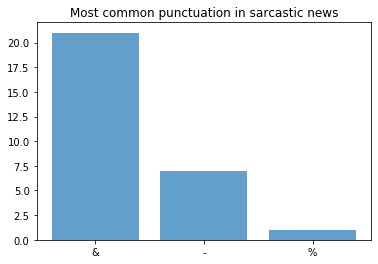

In [22]:
x,y = zip(*sorted(punc_sar.items(), key = lambda x : x[1], reverse = True))
plt.title('Most common punctuation in sarcastic news')
plt.bar(x,y, alpha = 0.7)

In [23]:
punc_nor = defaultdict(int)

for word in corpus_nor:
    if word in string.punctuation:
        punc_nor[word] +=1

<BarContainer object of 8 artists>

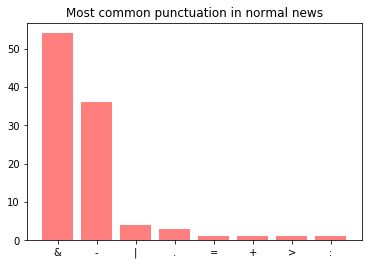

In [24]:
x,y = zip(*sorted(punc_nor.items(), key = lambda x : x[1], reverse = True))
plt.title('Most common punctuation in normal news')
plt.bar(x,y, color = 'r', alpha = 0.5)

Normal headlines utilize a wider range of punctuation

<h4> Sentiment Analysis of Headlines </h4>

In [25]:
polarity_sar = train_df[train_df['is_sarcastic'] == 1]['headline'].map(lambda text : TextBlob(text).sentiment.polarity)

Text(0.5, 1.0, 'Sentiment of sarcastic titles')

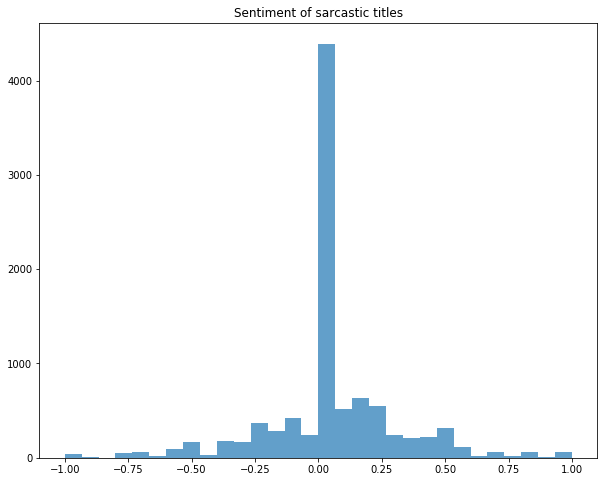

In [26]:
plt.figure(figsize = (10,8))
plt.hist(polarity_sar, bins = 30, alpha = 0.7)
plt.title('Sentiment of sarcastic titles')

In [27]:
polarity_nor = train_df[train_df['is_sarcastic'] == 0]['headline'].map(lambda text : TextBlob(text).sentiment.polarity)

Text(0.5, 1.0, 'Sentiment of normal titles')

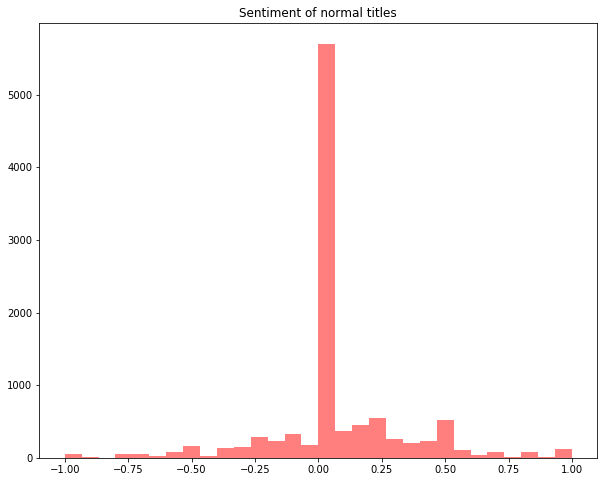

In [28]:
plt.figure(figsize = (10,8))
plt.hist(polarity_nor, bins = 30, color = 'r', alpha = 0.5)
plt.title('Sentiment of normal titles')

There is no strong negative or positive inclination in both normal and sarcastic titles 

<h2><b> 2. Data Cleaning </b></h2>

<h3>2a. Normalization and Tokenization<h3>

First convert all text to lower case 

Remove punctuation

In [29]:
def process(sentence): 
    return [word.lower() for word in sentence.split() if word not in string.punctuation]
        

In [30]:
train_df['headline'] = train_df['headline'].apply(lambda x : process(x))
test_df['headline'] = test_df['headline'].apply(lambda x : process(x))

<h3>2b. Stop Word Removal<h3>

In [32]:
def process(sentence_list):
    return [word for word in sentence_list if word not in stopwords.words('english')]

In [33]:
train_df['headline'] = train_df['headline'].apply(lambda x : process(x))
test_df['headline'] = test_df['headline'].apply(lambda x : process(x))

<h3> 2c. Lemmatization </h3>

In [35]:
from nltk.stem import WordNetLemmatizer 

In [36]:
from nltk.corpus import wordnet
def get_wordnet_pos(word):
    first_char = nltk.pos_tag(word)[0][1][0].upper()
    tag_dict = {
        'J' : wordnet.ADJ,
        'N' : wordnet.NOUN,
        'V' : wordnet.VERB,
        'R' : wordnet.ADV, 
        #'P' : wordnet.ADJ
    }
    return tag_dict.get(first_char, wordnet.NOUN)

In [37]:
def lemmatization(list):
    
    return [lemmatizer.lemmatize(word, get_wordnet_pos([word])) for word in list]
        

In [38]:
lemmatizer = WordNetLemmatizer() 
train_df['headline'] = train_df['headline'].apply(lambda sentence : lemmatization(sentence))
test_df['headline'] = test_df['headline'].apply(lambda sentence : lemmatization(sentence))

<h2> 3. Word Cloud </h2>

Wordclouds show how important a word is. More frequent words occupy greater space 

In [40]:
def clean_corpus(num):
    corpus = []
    for sentence_list in train_df[train_df['is_sarcastic'] == num]['headline']:
        for word in sentence_list:
            corpus.append(word)
    return corpus

In [41]:
corpus_sar = clean_corpus(1)

In [42]:
corpus_nor = clean_corpus(0)

In [43]:
len(corpus_sar)

73923

In [44]:
len(corpus_nor)

72687

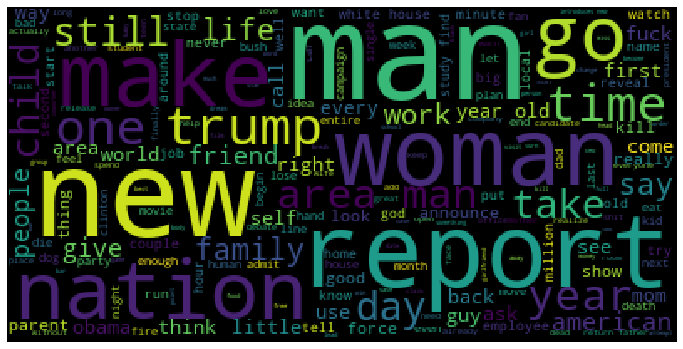

In [45]:
from wordcloud import WordCloud

plt.figure(figsize = (12,8))

word_cloud = WordCloud(background_color = 'black', max_font_size = 80).generate(" ".join(corpus_sar))

plt.imshow(word_cloud)
plt.axis('off')
plt.show()

Man is the most frequent word in sarcastic headlines

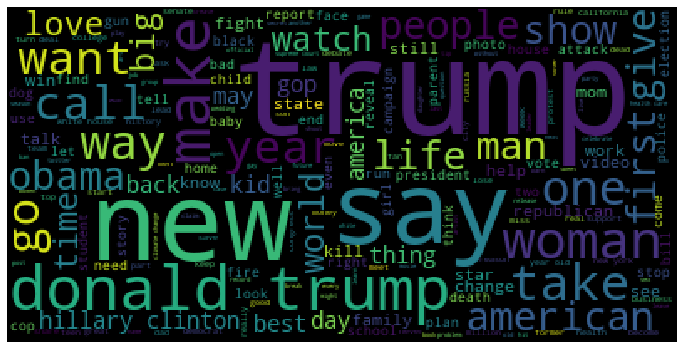

In [46]:
from wordcloud import WordCloud

plt.figure(figsize = (12,8))

word_cloud = WordCloud(background_color = 'black', max_font_size = 80).generate(" ".join(corpus_nor))

plt.imshow(word_cloud)
plt.axis('off')
plt.show()

Trump is the most frequent word in normal headlines

<h2>4. BAG OF WORDS </h2>

Counting the number of appearances of each word in a document

Train and test vectors need to use the same set of tokens 

In [47]:
def clean_corpus_total(sentence):
    return " ".join(sentence)

In [48]:
X_train = train_df['headline'].apply(lambda sentence : clean_corpus_total(sentence)).to_numpy()

In [49]:
X_test = test_df['headline'].apply(lambda sentence : clean_corpus_total(sentence)).to_numpy()

In [50]:
y_train = train_df['is_sarcastic'].to_numpy()
y_test = test_df['is_sarcastic'].to_numpy()

In [51]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vector_train = vectorizer.fit_transform(X_train)
vector_test = vectorizer.transform(X_test)

In [52]:
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()
mnb.fit(vector_train,y_train)
mnb_prediction = mnb.predict(vector_test)

In [53]:
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(y_test, mnb_prediction))
print(classification_report(y_test, mnb_prediction))

[[3607  883]
 [ 900 3196]]
              precision    recall  f1-score   support

           0       0.80      0.80      0.80      4490
           1       0.78      0.78      0.78      4096

    accuracy                           0.79      8586
   macro avg       0.79      0.79      0.79      8586
weighted avg       0.79      0.79      0.79      8586



In [54]:
mnb_prediction[345]

0

In [55]:
y_test[345]

1

In [56]:
X_test[345]

'gwyneth paltrow report news'

<h2> 5. TF-IDF </h2>

Vectorization technique to measure originality of a word 

 TF: Term Frequency in a document
 
 IDF: Frequency of the word across all documents 
 
 tf * log(N/df) where N is the total number of documents

In [57]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
vector_train = vectorizer.fit_transform(X_train)
vector_test = vectorizer.transform(X_test)

In [58]:
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()
mnb.fit(vector_train,y_train)
mnb_prediction = mnb.predict(vector_test)

In [59]:
print(confusion_matrix(y_test, mnb_prediction))
print(classification_report(y_test, mnb_prediction))

[[3767  723]
 [1064 3032]]
              precision    recall  f1-score   support

           0       0.78      0.84      0.81      4490
           1       0.81      0.74      0.77      4096

    accuracy                           0.79      8586
   macro avg       0.79      0.79      0.79      8586
weighted avg       0.79      0.79      0.79      8586



In [60]:
mnb_prediction[345]

0

In [61]:
y_test[345]

1


Limitation of BOW, TF-IDF ==> they have no notion of context/similarity relationships between words (Wordnet doesnt understand nuances)

<h2> 6. Word2Vec </h2>

CBOW - uses context to predict current word

SG - uses current word to predict context 

NN structure 

input layer is one encoded

Each word has 2 vector represantations - one as center vector and one as context vector

In [94]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(20033,)
(8586,)
(20033,)
(8586,)


In [95]:
%%time
documents = [text.split() for text in X_train]

CPU times: user 43.5 ms, sys: 14.2 ms, total: 57.7 ms
Wall time: 57.4 ms


In [96]:
documents[0:5]

[["'very",
  'angry',
  "badger'",
  'seizes',
  'part',
  '500-year-old',
  'scottish',
  'castle'],
 ['comic-con', 'open', 'traditional', 'superhero', 'flyover'],
 ['divestment', '--', 'walk', 'away', 'make', 'difference'],
 ['area', '93-year-old', 'death-after-life', 'experience'],
 ['man',
  'excite',
  'give',
  'visit',
  'friend',
  'real',
  'fort',
  'wayne',
  'experience']]

In [97]:
from gensim.models import Word2Vec

w2v_model = Word2Vec(size = 300, window=5, min_count=2, workers=8)

In [98]:
w2v_model.build_vocab(documents)

In [99]:
words = w2v_model.wv.vocab.keys()
print('vocab size', len(words))

vocab size 11220


In [100]:
%%time
w2v_model.train(documents,total_examples=len(documents),epochs=32)

CPU times: user 20.5 s, sys: 225 ms, total: 20.7 s
Wall time: 8.04 s


(4112097, 4691520)

In [101]:
w2v_model.most_similar("comic-con")

<ipython-input-101-c2264106d96e>:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  w2v_model.most_similar("comic-con")


[('michelangelo', 0.9754325747489929),
 ('ref', 0.9737936854362488),
 ('audible', 0.9729962348937988),
 ('superhero', 0.9723808765411377),
 ('real-life', 0.9721829295158386),
 ('randomly', 0.9707149863243103),
 ('for,', 0.9706093072891235),
 ('storyline', 0.9704914093017578),
 ('protagonist', 0.9703436493873596),
 ('meditate', 0.9700598120689392)]

In [102]:
#w2v_model.wv.doesnt_match(['scottish', 'castle', 'superhero'])

In [103]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 22265
CPU times: user 482 ms, sys: 26.9 ms, total: 509 ms
Wall time: 367 ms


In [104]:
X_train_w2v = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=15)
X_test_w2v = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=15)

In [196]:
pd.DataFrame(X_train_w2v).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0,0,0,0,0,2454,2022,10907,6025,224,2023,7,23,4344,2639
1,0,0,0,0,0,0,0,0,0,1903,2298,142,2455,3122,7689
2,0,0,0,0,0,0,0,0,0,0,10908,313,237,6,1904
3,0,0,0,0,0,0,0,15,2845,7,23,72,4345,20,491
4,0,0,0,0,0,0,3,554,30,287,100,140,6026,4346,491


In [106]:
print("X_train", X_train_w2v.shape)
print("y_train", y_train.shape)
print()
print("X_test", X_test_w2v.shape)
print("y_val", y_test.shape)

X_train (20033, 15)
y_train (20033,)

X_test (8586, 15)
y_val (8586,)


In [107]:
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]

In [108]:
print(embedding_matrix.shape)

(22265, 300)


In [109]:
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=15, trainable=False)

In [110]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 15, 300)           6679500   
_________________________________________________________________
dropout_2 (Dropout)          (None, 15, 300)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                93440     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 6,773,005
Trainable params: 93,505
Non-trainable params: 6,679,500
_________________________________________________________________


In [111]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [112]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [114]:
%%time
history = model.fit(X_train_w2v, y_train,
                    batch_size=256,
                    epochs=10,
                    validation_data = (X_test_w2v,y_test),
                    verbose=1,
                    callbacks=callbacks)

Train on 20033 samples, validate on 8586 samples
Epoch 1/10
20033/20033 [==============================] - 5s 260us/step - loss: 0.5976 - accuracy: 0.6706 - val_loss: 0.5553 - val_accuracy: 0.7021
Epoch 2/10
  768/20033 [>.............................] - ETA: 4s - loss: 0.5565 - accuracy: 0.7109

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/callbacks/callbacks.py:843: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  warnings.warn(


20033/20033 [==============================] - 5s 231us/step - loss: 0.5512 - accuracy: 0.7112 - val_loss: 0.5393 - val_accuracy: 0.7167
Epoch 3/10
20033/20033 [==============================] - 5s 238us/step - loss: 0.5386 - accuracy: 0.7198 - val_loss: 0.5251 - val_accuracy: 0.7276
Epoch 4/10
20033/20033 [==============================] - 5s 269us/step - loss: 0.5268 - accuracy: 0.7278 - val_loss: 0.5132 - val_accuracy: 0.7364
Epoch 5/10
20033/20033 [==============================] - 6s 321us/step - loss: 0.5185 - accuracy: 0.7362 - val_loss: 0.5128 - val_accuracy: 0.7381
Epoch 6/10
20033/20033 [==============================] - 11s 554us/step - loss: 0.5098 - accuracy: 0.7383 - val_loss: 0.5124 - val_accuracy: 0.7341
Epoch 7/10
20033/20033 [==============================] - 12s 600us/step - loss: 0.5058 - accuracy: 0.7429 - val_loss: 0.4983 - val_accuracy: 0.7504
Epoch 8/10
20033/20033 [==============================] - 10s 477us/step - loss: 0.4976 - accuracy: 0.7482 - val_loss: 0.

In [157]:
score = model.evaluate(X_test_w2v, y_test, batch_size=256)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

8586/8586 [==============================] - 1s 79us/step

ACCURACY: 0.7831353545188904
LOSS: 0.45141249699329344


No handles with labels found to put in legend.


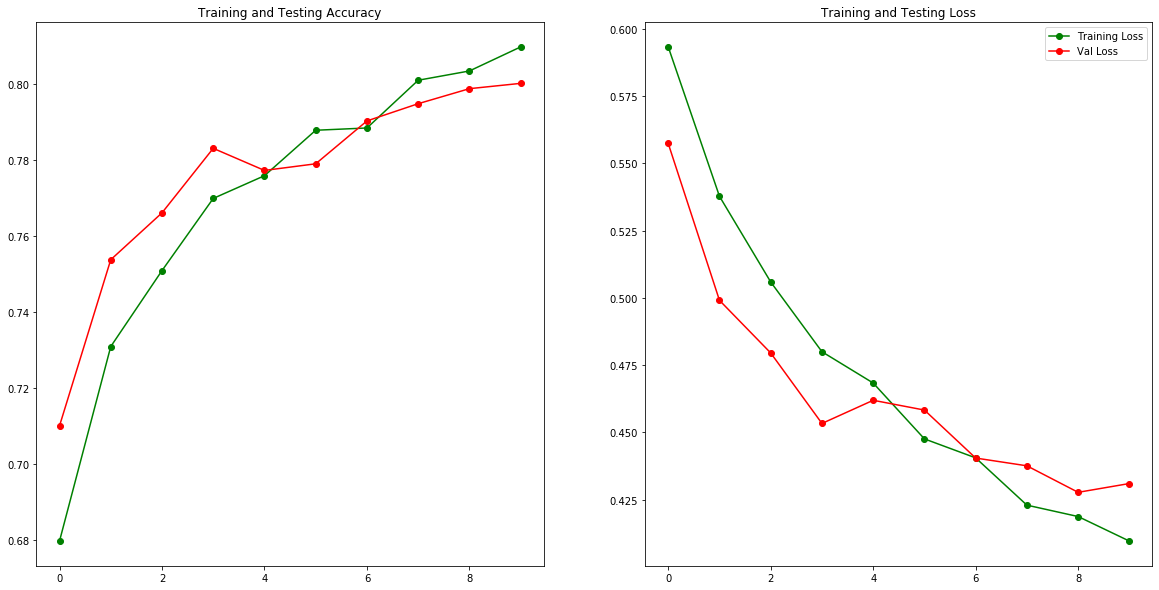

In [176]:
epoch = [i for i in range(10)]

fig,axes = plt.subplots(1,2)
train_acc = model.history.history['accuracy']
train_loss = model.history.history['loss']

val_acc = model.history.history['val_accuracy']
val_loss = model.history.history['val_loss']
fig.set_size_inches(20,10)

axes[0].plot(epoch, train_acc, 'go-', label = 'Training Accuracy')
axes[0].plot(epoch, val_acc, 'ro-', label = 'Val Accuracy')
axes[0].set_title('Training and Testing Accuracy')
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")
plt.legend()

axes[1].plot(epoch, train_loss, 'go-', label = 'Training Loss')
axes[1].plot(epoch, val_loss, 'ro-', label = 'Val Loss')
axes[1].set_title('Training and Testing Loss')
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

plt.legend()


<h2> 7. GloVe </h2>

Semtantic info is in co-occurence matrix 

In [184]:
embedding_dict = {}

with open('/Users/mahima.sharma/Desktop/glove.6B/glove.6B.100d.txt', 'r') as f:
    for line in f:
        vals = line.split(' ')
        word = vals[0]
        vectors = np.asarray(vals[1:], 'float32')
        embedding_dict[word] = vectors
        
f.close()

In [185]:
embedding_dict['the']

array([-0.038194, -0.24487 ,  0.72812 , -0.39961 ,  0.083172,  0.043953,
       -0.39141 ,  0.3344  , -0.57545 ,  0.087459,  0.28787 , -0.06731 ,
        0.30906 , -0.26384 , -0.13231 , -0.20757 ,  0.33395 , -0.33848 ,
       -0.31743 , -0.48336 ,  0.1464  , -0.37304 ,  0.34577 ,  0.052041,
        0.44946 , -0.46971 ,  0.02628 , -0.54155 , -0.15518 , -0.14107 ,
       -0.039722,  0.28277 ,  0.14393 ,  0.23464 , -0.31021 ,  0.086173,
        0.20397 ,  0.52624 ,  0.17164 , -0.082378, -0.71787 , -0.41531 ,
        0.20335 , -0.12763 ,  0.41367 ,  0.55187 ,  0.57908 , -0.33477 ,
       -0.36559 , -0.54857 , -0.062892,  0.26584 ,  0.30205 ,  0.99775 ,
       -0.80481 , -3.0243  ,  0.01254 , -0.36942 ,  2.2167  ,  0.72201 ,
       -0.24978 ,  0.92136 ,  0.034514,  0.46745 ,  1.1079  , -0.19358 ,
       -0.074575,  0.23353 , -0.052062, -0.22044 ,  0.057162, -0.15806 ,
       -0.30798 , -0.41625 ,  0.37972 ,  0.15006 , -0.53212 , -0.2055  ,
       -1.2526  ,  0.071624,  0.70565 ,  0.49744 , 

In [186]:
embedding_matrix = np.zeros((vocab_size, 100))

for word, i in tokenizer.word_index.items():
    weights = embedding_dict.get(word)
    
    if weights is not None:
        embedding_matrix[i] = weights;

In [187]:
embedding_matrix[1]

array([-4.39589992e-02,  1.89359993e-01,  6.61099970e-01, -4.90069985e-01,
        3.22109997e-01, -3.41610014e-01, -6.84799999e-02,  3.13639998e-01,
       -7.11420000e-01,  5.74360013e-01, -3.35880011e-01, -5.22790015e-01,
       -3.90749991e-01, -8.96940008e-02,  4.63710010e-01, -3.56099993e-01,
        8.45759988e-01, -2.61879992e-02, -1.93279997e-01, -8.38460028e-02,
        3.18060011e-01, -1.98119998e-01,  3.00089985e-01,  6.91889971e-02,
        5.44700027e-01, -5.91929972e-01,  5.42209983e-01, -6.28759980e-01,
       -5.34470022e-01,  4.23339993e-01,  3.08689997e-02,  9.71639991e-01,
       -5.62219977e-01,  4.57520001e-02, -5.70999980e-01,  8.01850036e-02,
       -8.14339966e-02, -6.02599978e-01,  1.64660007e-01, -4.02810007e-01,
       -4.77010012e-01, -5.19500017e-01,  1.27770007e-01, -4.37750012e-01,
        2.66020000e-01,  4.87520009e-01, -6.02199994e-02, -5.26220024e-01,
        3.76870006e-01, -1.80069998e-01,  3.01660001e-02, -9.45769995e-02,
        1.63299993e-01,  

In [188]:
model = Sequential()

embedding_layer = embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=15, trainable=False)

model.add(embedding_layer)
model.add(Dropout(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

In [189]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [190]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 15, 100)           2226500   
_________________________________________________________________
dropout_6 (Dropout)          (None, 15, 100)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 2,243,557
Trainable params: 17,057
Non-trainable params: 2,226,500
_________________________________________________________________


In [191]:
model.fit(X_train_w2v,y_train,batch_size=32,epochs=10,validation_data=(X_test_w2v,y_test))

Train on 20033 samples, validate on 8586 samples
Epoch 1/10
20033/20033 [==============================] - 10s 476us/step - loss: 0.5985 - accuracy: 0.6766 - val_loss: 0.5411 - val_accuracy: 0.7292
Epoch 2/10
20033/20033 [==============================] - 9s 449us/step - loss: 0.5492 - accuracy: 0.7205 - val_loss: 0.5207 - val_accuracy: 0.7409
Epoch 3/10
20033/20033 [==============================] - 9s 459us/step - loss: 0.5240 - accuracy: 0.7398 - val_loss: 0.4984 - val_accuracy: 0.7558
Epoch 4/10
20033/20033 [==============================] - 9s 466us/step - loss: 0.5020 - accuracy: 0.7515 - val_loss: 0.4844 - val_accuracy: 0.7588
Epoch 5/10
20033/20033 [==============================] - 9s 470us/step - loss: 0.4876 - accuracy: 0.7624 - val_loss: 0.4756 - val_accuracy: 0.7648
Epoch 6/10
20033/20033 [==============================] - 9s 469us/step - loss: 0.4763 - accuracy: 0.7686 - val_loss: 0.4766 - val_accuracy: 0.7673
Epoch 7/10
20033/20033 [==============================] - 10s 

In [192]:
score = model.evaluate(X_test_w2v, y_test, batch_size=256)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

8586/8586 [==============================] - 0s 43us/step

ACCURACY: 0.7849988341331482
LOSS: 0.4466912310744898


No handles with labels found to put in legend.


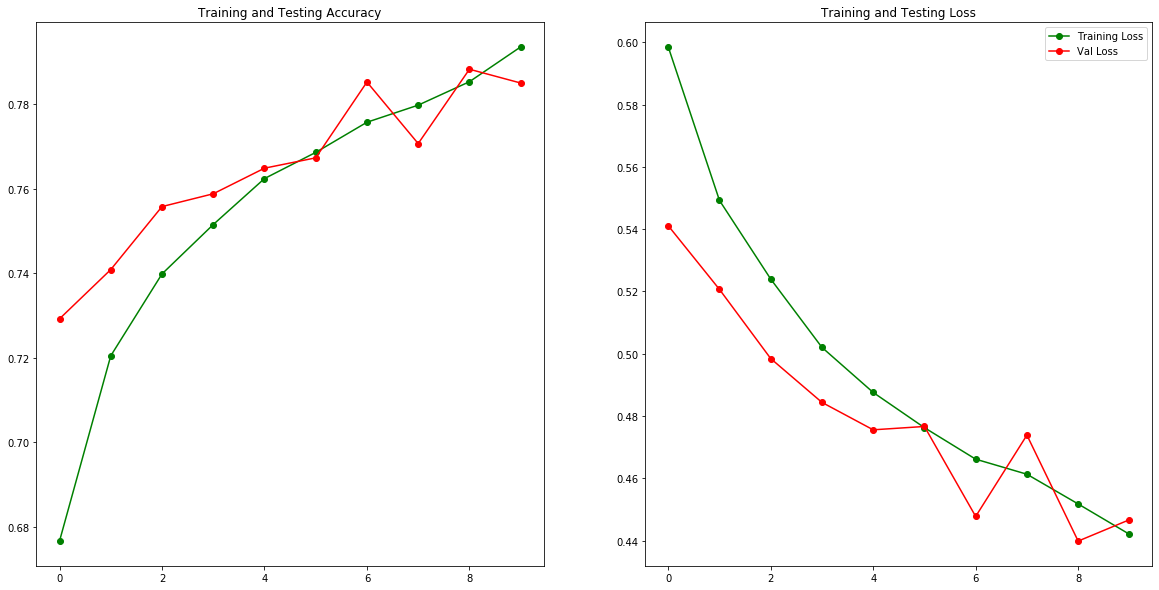

In [193]:
epoch = [i for i in range(10)]

fig,axes = plt.subplots(1,2)
train_acc = model.history.history['accuracy']
train_loss = model.history.history['loss']

val_acc = model.history.history['val_accuracy']
val_loss = model.history.history['val_loss']
fig.set_size_inches(20,10)

axes[0].plot(epoch, train_acc, 'go-', label = 'Training Accuracy')
axes[0].plot(epoch, val_acc, 'ro-', label = 'Val Accuracy')
axes[0].set_title('Training and Testing Accuracy')
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")
plt.legend()

axes[1].plot(epoch, train_loss, 'go-', label = 'Training Loss')
axes[1].plot(epoch, val_loss, 'ro-', label = 'Val Loss')
axes[1].set_title('Training and Testing Loss')
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

plt.legend()